# 0. Environment

## 0-1. check and install

In [1]:
!python --version

Python 3.8.10


In [2]:
import tensorflow as tf
print('tensorflow version:', tf.__version__)

tensorflow version: 2.6.1


In [3]:
!apt update
!apt install wget
!apt install libsndfile1-dev -y

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                   
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Fetched 336 kB in 3s (124 kB/s)     33m
Reading package lists... Done
Building dependency tree   

In [4]:
!python -m pip install --upgrade pip 
!python -m pip install librosa
!python -m pip install python_speech_features
!python -m pip install seaborn

## 0-2. set parameter

In [5]:
# set dataset path
dataset_path = './data_speech_commands_v002'

# 1. Prepare dataset

## 1-1. get dataset

In [6]:
import os
# get speech_commands from google's server
if not os.path.exists(dataset_path):
    if not os.path.isfile('speech_commands_v0.02.tar.gz') :
        !wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
    !mkdir data_speech_commands_v002
    !tar zxvf "./speech_commands_v0.02.tar.gz" --directory data_speech_commands_v002

## 1-2. dataset details

In [7]:
import numpy as np
# list the folders in the dataset
dataset_dirslist = np.array(tf.io.gfile.listdir(str(dataset_path)))
print ('dataset_dirslist:', dataset_dirslist,', num: ' , len(dataset_dirslist))
print('-')

# delete the files and folders which don't contain the trainable command folders from the list
dataset_commands_dirslist = dataset_dirslist
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'README.md']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != '.DS_Store']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'validation_list.txt']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'testing_list.txt']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'LICENSE']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != '_background_noise_']
print ('dataset_commands_dirslist:', dataset_commands_dirslist,', num: ' , len(dataset_commands_dirslist))

dataset_dirslist: ['testing_list.txt' 'wow' 'yes' 'dog' 'go' 'off' 'on' 'visual' 'up' 'left'
 'one' 'eight' 'no' 'learn' 'backward' 'follow' 'stop' 'cat' 'four' 'bed'
 'marvin' 'nine' 'three' 'README.md' 'house' 'bird' 'happy' 'down' 'zero'
 '_background_noise_' 'validation_list.txt' 'six' 'LICENSE' 'tree' 'right'
 'five' 'two' '.DS_Store' 'sheila' 'seven' 'forward'] , num:  41
-
dataset_commands_dirslist: ['wow' 'yes' 'dog' 'go' 'off' 'on' 'visual' 'up' 'left' 'one' 'eight' 'no'
 'learn' 'backward' 'follow' 'stop' 'cat' 'four' 'bed' 'marvin' 'nine'
 'three' 'house' 'bird' 'happy' 'down' 'zero' 'six' 'tree' 'right' 'five'
 'two' 'sheila' 'seven' 'forward'] , num:  35


## 1-3. dataset commands filepaths

In [8]:
import random
# list the num of audio files in each command folder
dataset_commands_filepaths = []
for item in dataset_commands_dirslist:
    dataset_commands_dir = os.path.join(dataset_path, item,'*')
    print('dataset_commands_dir:', dataset_commands_dir)
    fileslist = tf.io.gfile.glob(dataset_commands_dir)
    print('file num of',item,':', len(fileslist))
    dataset_commands_filepaths.extend(fileslist)
    print('-')
print('num of dataset_commands_filepaths:', len(dataset_commands_dirslist))
print('num of dataset_commands_filepaths:', len(dataset_commands_filepaths))
tmp_sample = dataset_commands_filepaths[random.randrange(len(dataset_commands_filepaths))]
print('tmp_sample of dataset_commands_filepaths:', tmp_sample)

dataset_commands_dir: ./data_speech_commands_v002/wow/*
file num of wow : 2123
-
dataset_commands_dir: ./data_speech_commands_v002/yes/*
file num of yes : 4044
-
dataset_commands_dir: ./data_speech_commands_v002/dog/*
file num of dog : 2128
-
dataset_commands_dir: ./data_speech_commands_v002/go/*
file num of go : 3880
-
dataset_commands_dir: ./data_speech_commands_v002/off/*
file num of off : 3745
-
dataset_commands_dir: ./data_speech_commands_v002/on/*
file num of on : 3845
-
dataset_commands_dir: ./data_speech_commands_v002/visual/*
file num of visual : 1592
-
dataset_commands_dir: ./data_speech_commands_v002/up/*
file num of up : 3723
-
dataset_commands_dir: ./data_speech_commands_v002/left/*
file num of left : 3801
-
dataset_commands_dir: ./data_speech_commands_v002/one/*
file num of one : 3890
-
dataset_commands_dir: ./data_speech_commands_v002/eight/*
file num of eight : 3787
-
dataset_commands_dir: ./data_speech_commands_v002/no/*
file num of no : 3941
-
dataset_commands_dir: ./

# 2. Audio Preporcess

## 2-1. function

### 2-1-1. split num

In [9]:
# get the start index to split the dataset  
def get_split_num(train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1, file_num = 0):
    #get train , val, test num
    train_num = int( file_num * train_ratio )
    val_num = int( file_num * val_ratio )
    test_num = file_num - train_num - val_num 

    #get train , val, test first_num
    train_first_num = 0
    val_first_num = train_num
    test_first_num = train_num + val_num
    
    return train_first_num, val_first_num, test_first_num

### 2-1-2. label

In [10]:
# get label from the filepath of audio file
def get_label(filepath):
    split_1=os.path.split(filepath)
    split_2=os.path.split(split_1[0])
    return split_2[1]

In [11]:
tmp = get_label(tmp_sample)
print ('get_label(tmp_sample):')
print (type(tmp))
print (tmp)

get_label(tmp_sample):
<class 'str'>
nine


### 2-1-3. waveform

In [12]:
import librosa
# load waveform from the filepath
def get_waveform(filepath):
    sample_rate = 16000
    waveform, fs = librosa.load(filepath, sr=sample_rate)
    return waveform

get_waveform(tmp_sample):
<class 'numpy.ndarray'>
(16000,)
[-0.00146484 -0.00350952 -0.00314331 ... -0.00646973 -0.00567627
 -0.00570679]


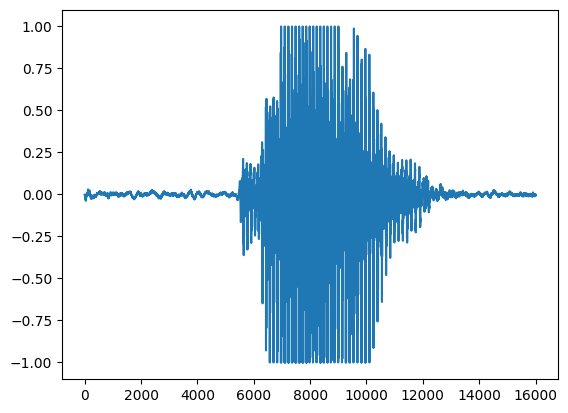

In [13]:
from IPython import display
import matplotlib.pyplot as plt
tmp = get_waveform(tmp_sample)
print ('get_waveform(tmp_sample):')
print (type(tmp))
print (tmp.shape)
print (tmp)
sample_rate = 16000
plt.plot(np.arange(sample_rate), tmp)
plt.show()
display.display(display.Audio(tmp, rate=sample_rate))

### 2-1-4. label id

In [14]:
# get label id from label and command_list
def get_label_id(label,command_list):
    label_id = np.argmax(label==command_list)
    return label_id

In [15]:
tmp = get_label_id(get_label(tmp_sample),dataset_commands_dirslist)
print ('get_label_id(get_label(tmp_sample):')
print (type(tmp))
print (tmp)

get_label_id(get_label(tmp_sample):
<class 'numpy.int64'>
20


### 2-1-5. MFCC-python_speech_features

In [16]:
import python_speech_features
import matplotlib.pyplot as plt
def get_features_psf(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    # input_len = 16000
    # waveform = waveform[:input_len]
    # np.shape(waveform) =  (16000,)
    zero_padding = np.zeros( (16000-np.shape(waveform)[0],), dtype=np.float32)
    # Cast the waveform tensors with np.float32
    waveform = np.cast['float32'](waveform)
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length = np.concatenate([waveform, zero_padding], 0)
    
    sample_rate = 16000
    num_mfcc = 16
    len_mfcc = 40
    mfccs = python_speech_features.base.mfcc(equal_length, 
                                            samplerate=sample_rate,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=4096,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

get_features_psf(get_waveform(tmp_sample)):
type: <class 'numpy.ndarray'>
shape: (16, 16)


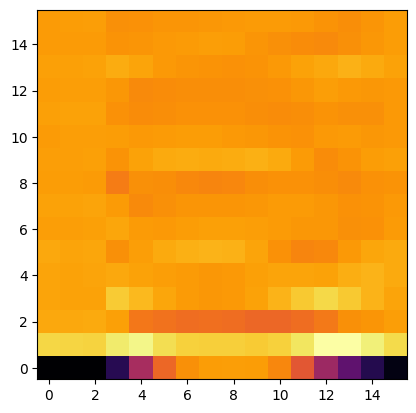

In [17]:
tmp = get_features_psf(get_waveform(tmp_sample))
print ('get_features_psf(get_waveform(tmp_sample)):')
print ('type:',type(tmp))
print ('shape:',tmp.shape)
#print (tmp)
fig = plt.figure()
plt.imshow(tmp, cmap='inferno', origin='lower')
plt.show()

### 2-1-5. MFCC-librosa.feature.mfcc

In [51]:
import librosa
import matplotlib.pyplot as plt


def get_features(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    # input_len = 16000
    # waveform = waveform[:input_len]
    # np.shape(waveform) =  (16000,)
    zero_padding = np.zeros( (16000-np.shape(waveform)[0],), dtype=np.float32)
    # Cast the waveform tensors with np.float32
    waveform = np.cast['float32'](waveform)
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length_waveform = np.concatenate([waveform, zero_padding], 0)
        
    
    sr = 16000
    n_mfcc = 64
    n_mels = 64
    n_fft = 512 
    window_stride = 0.01
    hop_length = int(sr*window_stride)
    fmin = 0
    fmax = None
    
    
    mfcc_librosa = librosa.feature.mfcc(y=equal_length_waveform, sr=sr, n_fft=n_fft,
                                        n_mfcc=n_mfcc, n_mels=n_mels,
                                        hop_length=hop_length,
                                        fmin=fmin, fmax=fmax, htk=False)
    
    return mfcc_librosa

get_features(get_waveform(tmp_sample)):
type: <class 'numpy.ndarray'>
shape: (64, 101)


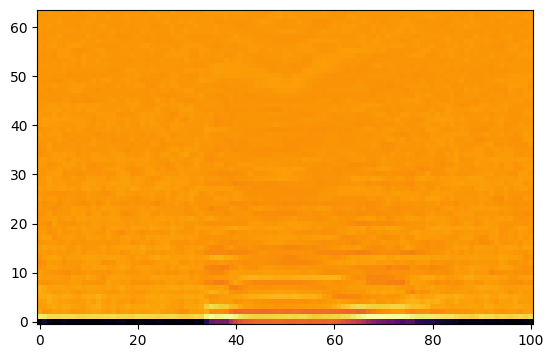

In [19]:
tmp = get_features(get_waveform(tmp_sample))
print ('get_features(get_waveform(tmp_sample)):')
print ('type:',type(tmp))
print ('shape:',tmp.shape)
#print (tmp)
fig = plt.figure()
plt.imshow(tmp, cmap='inferno', origin='lower')
plt.show()

## 2-2. Preporcess set commands

In [20]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

### 2-2-1. get set command filepaths

In [21]:
import random
random.seed(66)

# set want commands
commands = np.array(["yes","no","up","down","left","right","on","off","stop","go"])

train_set_commands_filepaths = []
val_set_commands_filepaths = []
test_set_commands_filepaths = []

# get set commands
set_commands_dirslist = commands
# get the filepaths and split to train, val, test every command
for item in set_commands_dirslist:
    # join the dataset_path and command
    set_commands_dir = os.path.join(dataset_path, item,'*')
    print('set_commands_dir:', set_commands_dir)
    
    # list the set command filepaths in each dir
    fileslist = tf.io.gfile.glob(set_commands_dir)
    random.shuffle(fileslist)
    print('file num :', len(fileslist))
    print('-')
    
    # split the filslist to train, val, test
    train, val, test = get_split_num(0.8, 0.1, 0.1, len(fileslist))
    train_set_commands_filepaths.extend(fileslist[:val])
    val_set_commands_filepaths.extend(fileslist[val:test])
    test_set_commands_filepaths.extend(fileslist[test:])  
# get the num of all tarinable audio files
total_set_commands_num = len(train_set_commands_filepaths)+len(val_set_commands_filepaths)+len(test_set_commands_filepaths)
    
print('num of train_set_commands_filepaths:', len(train_set_commands_filepaths))
print('num of val_set_commands_filepaths:', len(val_set_commands_filepaths))
print('num of test_set_commands_filepaths:', len(test_set_commands_filepaths))

print('total of set_commands_filepaths:',total_set_commands_num)
print('sample of train_set_commands_filepaths:', train_set_commands_filepaths[0])


set_commands_dir: ./data_speech_commands_v002/yes/*
file num : 4044
-
set_commands_dir: ./data_speech_commands_v002/no/*
file num : 3941
-
set_commands_dir: ./data_speech_commands_v002/up/*
file num : 3723
-
set_commands_dir: ./data_speech_commands_v002/down/*
file num : 3917
-
set_commands_dir: ./data_speech_commands_v002/left/*
file num : 3801
-
set_commands_dir: ./data_speech_commands_v002/right/*
file num : 3778
-
set_commands_dir: ./data_speech_commands_v002/on/*
file num : 3845
-
set_commands_dir: ./data_speech_commands_v002/off/*
file num : 3745
-
set_commands_dir: ./data_speech_commands_v002/stop/*
file num : 3872
-
set_commands_dir: ./data_speech_commands_v002/go/*
file num : 3880
-
num of train_set_commands_filepaths: 30833
num of val_set_commands_filepaths: 3851
num of test_set_commands_filepaths: 3862
total of set_commands_filepaths: 38546
sample of train_set_commands_filepaths: ./data_speech_commands_v002/yes/bfd26d6b_nohash_3.wav


### 2-2-2. get features and label id

In [22]:
train_set_commands_features = []
val_set_commands_features = []
test_set_commands_features = []

train_set_commands_label_id = []
val_set_commands_label_id = []
test_set_commands_label_id = []

# get features and label id and append to train_set_commands_features and train_set_commands_label_id
for i, item in enumerate(train_set_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    train_set_commands_features.append(features)

    label = get_label(item)
    label_id = get_label_id(label,commands)
    train_set_commands_label_id.append(label_id)

    
# get features and label id and append to val_set_commands_features and val_set_commands_label_id
for i, item in enumerate(val_set_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    val_set_commands_features.append(features)

    label = get_label(item)
    label_id = get_label_id(label,commands)
    val_set_commands_label_id.append(label_id)

# get features and label id and append to test_set_commands_features and test_set_commands_label_id    
for i, item in enumerate(test_set_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    test_set_commands_features.append(features)

    label = get_label(item)
    label_id = get_label_id(label,commands)
    test_set_commands_label_id.append(label_id)        
        

print ('num of train_set_commands_features:', len(train_set_commands_features))
print ('num of train_set_commands_label_id:', len(train_set_commands_label_id))
print('-')
print ('num of val_set_commands_features:', len(val_set_commands_features))
print ('num of val_set_commands_label_id:', len(val_set_commands_label_id))
print('-')
print ('num of test_set_commands_features:', len(test_set_commands_features))
print ('num of test_set_commands_label_id:', len(test_set_commands_label_id)) 


num of train_set_commands_features: 30833
num of train_set_commands_label_id: 30833
-
num of val_set_commands_features: 3851
num of val_set_commands_label_id: 3851
-
num of test_set_commands_features: 3862
num of test_set_commands_label_id: 3862


### 2-2-3. add features and label id to dataset

In [23]:
# add features and label id to train list
x_train.extend(train_set_commands_features)
y_train.extend(train_set_commands_label_id)

# add features and label id to val list
x_val.extend(val_set_commands_features)
y_val.extend(val_set_commands_label_id)

# add features and label id to test list
x_test.extend(test_set_commands_features)
y_test.extend(test_set_commands_label_id)

print('num of x_train:',len(y_train))
print('num of y_train:',len(y_train))
print('-')
print('num of x_val:',len(x_val))
print('num of y_val:',len(y_val))
print('-')
print('num of x_test:',len(x_test))
print('num of y_test:',len(y_test))

num of x_train: 30833
num of y_train: 30833
-
num of x_val: 3851
num of y_val: 3851
-
num of x_test: 3862
num of y_test: 3862


## 2-3. Preporcess unknown commands

### 2-3-1. get unknown command filepaths

In [24]:
train_unknown_commands_filepaths = []
val_unknown_commands_filepaths = []
test_unknown_commands_filepaths = []

# add unknown to commands list
if not np.any(commands=='unknown'):
    commands = np.append(commands,'unknown')
print ('commands:',commands)
print('-')

# get the unknown commands which are not set commands and add them to the list
unknown_commands_dirslist = np.setdiff1d( dataset_commands_dirslist , commands)
print ('unknown_commands_dirslist:',unknown_commands_dirslist)
print('-')

# set the ratio of unknown command filepaths to set command filepaths
unknown_ratio = 0.1
print('unknown_ratio:',unknown_ratio)
print ('total_set_commands_num:', total_set_commands_num)
# get the num of unknown command filepaths
unknown_command_num = int(total_set_commands_num * unknown_ratio)
print ('unknown_command_num:', unknown_command_num)
# get the the num of each unknown command filepaths
each_unknown_command_num = unknown_command_num//len(unknown_commands_dirslist)
print ('each_unknown_command_num:', each_unknown_command_num)
print('-')

# get the filepaths and split to train, val, test every command
for item in unknown_commands_dirslist:
    # join the dataset_path and command
    unknown_commands_dir = os.path.join(dataset_path, item,'*')
    print('unknown_commands_dir:', unknown_commands_dir)
    
    # list the unknown command filepaths in each dir
    fileslist = tf.io.gfile.glob(unknown_commands_dir)
    random.shuffle(fileslist)
    print('file num :', len(fileslist))
    
    # split the filslist to train, val, test
    train, val, test = get_split_num(0.8, 0.1, 0.1, each_unknown_command_num)
    train_unknown_commands_filepaths.extend(fileslist[:val])
    val_unknown_commands_filepaths.extend(fileslist[val:test])
    test_unknown_commands_filepaths.extend(fileslist[test:each_unknown_command_num])
    print('-')
    
print('num of train_unknown_commands_filepaths:', len(train_unknown_commands_filepaths))
print('num of val_unknown_commands_filepaths:', len(val_unknown_commands_filepaths))
print('num of test_unknown_commands_filepaths:', len(test_unknown_commands_filepaths))

commands: ['yes' 'no' 'up' 'down' 'left' 'right' 'on' 'off' 'stop' 'go' 'unknown']
-
unknown_commands_dirslist: ['backward' 'bed' 'bird' 'cat' 'dog' 'eight' 'five' 'follow' 'forward'
 'four' 'happy' 'house' 'learn' 'marvin' 'nine' 'one' 'seven' 'sheila'
 'six' 'three' 'tree' 'two' 'visual' 'wow' 'zero']
-
unknown_ratio: 0.2
total_set_commands_num: 38546
unknown_command_num: 7709
each_unknown_command_num: 308
-
unknown_commands_dir: ./data_speech_commands_v002/backward/*
file num : 1664
-
unknown_commands_dir: ./data_speech_commands_v002/bed/*
file num : 2014
-
unknown_commands_dir: ./data_speech_commands_v002/bird/*
file num : 2064
-
unknown_commands_dir: ./data_speech_commands_v002/cat/*
file num : 2031
-
unknown_commands_dir: ./data_speech_commands_v002/dog/*
file num : 2128
-
unknown_commands_dir: ./data_speech_commands_v002/eight/*
file num : 3787
-
unknown_commands_dir: ./data_speech_commands_v002/five/*
file num : 4052
-
unknown_commands_dir: ./data_speech_commands_v002/follow/*


### 2-3-2. get features and label id

In [25]:
train_unknown_commands_features = []
val_unknown_commands_features = []
test_unknown_commands_features = []

train_unknown_commands_label_id = []
val_unknown_commands_label_id = []
test_unknown_commands_label_id = []

# get the unknown label and label_id
label = 'unknown'
label_id = get_label_id(label,commands)

# get features and label id and append to train_unknown_commands_features and train_unknown_commands_label_id
for i, item in enumerate(train_unknown_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    train_unknown_commands_features.append(features)
    train_unknown_commands_label_id.append(label_id)

# get features and label id and append to val_unknown_commands_features and val_unknown_commands_label_id
for i, item in enumerate(val_unknown_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    val_unknown_commands_features.append(features)
    val_unknown_commands_label_id.append(label_id)

# get features and label id and append to test_unknown_commands_features and test_unknown_commands_label_id
for i, item in enumerate(test_unknown_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    test_unknown_commands_features.append(features)
    test_unknown_commands_label_id.append(label_id)        
        

print ('num of train_unknown_commands_features:', len(train_unknown_commands_features))
print ('num of train_unknown_commands_label_id:', len(train_unknown_commands_label_id))
print('-')
print ('num of val_unknown_commands_features:', len(val_unknown_commands_features))
print ('num of val_unknown_commands_label_id:', len(val_unknown_commands_label_id))
print('-')
print ('num of test_unknown_commands_features:', len(test_unknown_commands_features))
print ('num of test_unknown_commands_label_id:', len(test_unknown_commands_label_id)) 

num of train_unknown_commands_features: 6150
num of train_unknown_commands_label_id: 6150
-
num of val_unknown_commands_features: 750
num of val_unknown_commands_label_id: 750
-
num of test_unknown_commands_features: 800
num of test_unknown_commands_label_id: 800


### 2-3-3. add features and label id to dataset

In [26]:
# add features and label id to train list
x_train.extend(train_unknown_commands_features)
y_train.extend(train_unknown_commands_label_id)
# add features and label id to val list
x_val.extend(val_unknown_commands_features)
y_val.extend(val_unknown_commands_label_id)
# add features and label id to test list
x_test.extend(test_unknown_commands_features)
y_test.extend(test_unknown_commands_label_id)

print('num of x_train:',len(x_train))
print('num of y_train:',len(y_train))
print('-')
print('num of x_val:',len(x_val))
print('num of y_val:',len(y_val))
print('-')
print('num of x_test:',len(x_test))
print('num of y_test:',len(y_test))

num of x_train: 36983
num of y_train: 36983
-
num of x_val: 4601
num of y_val: 4601
-
num of x_test: 4662
num of y_test: 4662


## 2-4. Preporcess slience command

### 2-4-1. get background command filepaths

In [27]:
train_slience_commands_filepaths = []
val_slience_commands_filepaths = []
test_slience_commands_filepaths = []

# add slience command to commands list
if not np.any(commands=='slience'):
    commands = np.append(commands,'slience')
print ('commands:',commands)
print('-')

# get background_noise to contruct slience samples
slience_commands_dirslist = ['_background_noise_']
print ('slience_commands_dirslist:',slience_commands_dirslist)
print('-')

# set the ratio of slience samples to set command filepaths
slience_ratio = 0.1
print ('total_set_commands_num:', total_set_commands_num)
print('slience_ratio:',slience_ratio)
# get the num of slience samples
slience_command_num = int(total_set_commands_num * slience_ratio)
print ('slience_command_num:', slience_command_num)
print('-')

# get the background_noise filepaths and append to train, val, test every filepaths
for item in slience_commands_dirslist:
    # join the dataset_path and background_noise files
    slience_commands_dir = os.path.join(dataset_path, item,'*.wav')
    print('slience_commands_dir:', slience_commands_dir)
    
    # get list of background_noise files
    fileslist = tf.io.gfile.glob(slience_commands_dir)
    print('file num :', len(fileslist))
    
    # get num of each background_noise files (the num to append for each files)
    each_slience_files = slience_command_num//len(fileslist)
    print ('each_slience_files:', each_slience_files)
  
    # get num of tarin , val ,test for each files
    train_num = int(each_slience_files*0.8)
    val_num = int(each_slience_files*0.1)
    test_num = int(each_slience_files*0.1)
    print('-')
    
    # every background_noise file
    for itme in fileslist:
        # append the filepath to train,val,test list for each files
        for i in range(train_num):
            train_slience_commands_filepaths.append(itme)
        for i in range(val_num):
            val_slience_commands_filepaths.append(itme)
        for i in range(test_num):
            test_slience_commands_filepaths.append(itme)

print('num of train_slience_commands_filepaths:', len(train_slience_commands_filepaths))
print('num of val_slience_commands_filepaths:', len(val_slience_commands_filepaths))
print('num of test_slience_commands_filepaths:', len(test_slience_commands_filepaths))
print('sample of train_slience_commands_filepaths:', train_slience_commands_filepaths[0])

commands: ['yes' 'no' 'up' 'down' 'left' 'right' 'on' 'off' 'stop' 'go' 'unknown'
 'slience']
-
slience_commands_dirslist: ['_background_noise_']
-
total_set_commands_num: 38546
slience_ratio: 0.1
slience_command_num: 3854
-
slience_commands_dir: ./data_speech_commands_v002/_background_noise_/*.wav
file num : 6
each_slience_files: 642
-
num of train_slience_commands_filepaths: 3078
num of val_slience_commands_filepaths: 384
num of test_slience_commands_filepaths: 384
sample of train_slience_commands_filepaths: ./data_speech_commands_v002/_background_noise_/doing_the_dishes.wav


### 2-4-2. contruct slience features and label id

In [28]:
#  ontruct slience features from background_noise
def get_random_background_noise_waveform(filepath):
    sample_rate = 16000
    # get waveform and len from filepath
    waveform = get_waveform(tmp_sample)  
    waveform_len = waveform.shape[0]
    # get start time by random(waveform_len)
    split_start_time = random.randrange(0, waveform_len)
    # get the 1s background_noise sample to represent slience feature
    waveform_split = waveform[split_start_time:split_start_time + sample_rate]
    # if the waveform_split not enough, the use the last 1s(16000)
    if waveform_split.shape[0] < sample_rate:
        waveform_split = waveform[-16000:-1]
    return waveform_split

In [29]:
# contruct slience features by zero vector
def get_zero_waveform():
    # get the 1s zero vector sample to represent slience feature
    zero_waveform = np.zeros((16000,), dtype=np.float32)
    return zero_waveform

In [30]:
train_slience_commands_features = []
val_slience_commands_features = []
test_slience_commands_features = []

train_slience_commands_label_id = []
val_slience_commands_label_id = []
test_slience_commands_label_id = []

# get the slience label and label_id
label = 'slience'
label_id = get_label_id(label,commands)

# get features and label id by get_random_background_noise_waveform and append them to train list
for i, item in enumerate(train_slience_commands_filepaths):
    background_noise_waveform = get_random_background_noise_waveform(item)
    features = get_features(background_noise_waveform)
    train_slience_commands_features.append(features)
    train_slience_commands_label_id.append(label_id)
# get features and label id by get_zero_waveform and append one sample to train list
zero_waveform = get_zero_waveform()
features = get_features(zero_waveform)
train_slience_commands_features.append(features)
train_slience_commands_label_id.append(label_id)

# get features and label id by get_random_background_noise_waveform and append them to val list
for i, item in enumerate(val_slience_commands_filepaths):
    background_noise_waveform = get_random_background_noise_waveform(item)
    features = get_features(background_noise_waveform)
    val_slience_commands_features.append(features)
    val_slience_commands_label_id.append(label_id)    
# get features and label id by get_zero_waveform and append one sample to val list
zero_waveform = get_zero_waveform()
features = get_features(zero_waveform)
val_slience_commands_features.append(features)
val_slience_commands_label_id.append(label_id)

# get features and label id by get_random_background_noise_waveform and append them to test list
for i, item in enumerate(test_slience_commands_filepaths):
    background_noise_waveform = get_random_background_noise_waveform(item)
    features = get_features(background_noise_waveform)
    test_slience_commands_features.append(features)
    test_slience_commands_label_id.append(label_id)    
# get features and label id by get_zero_waveform and append one sample to test list
zero_waveform = get_zero_waveform()
features = get_features(zero_waveform)
test_slience_commands_features.append(features)
test_slience_commands_label_id.append(label_id)

print ('num of train_slience_commands_features:', len(train_slience_commands_features))
print ('num of train_slience_commands_label_id:', len(train_slience_commands_label_id))
print('-')
print ('num of val_slience_commands_features:', len(val_slience_commands_features))
print ('num of val_slience_commands_label_id:', len(val_slience_commands_label_id))
print('-')
print ('num of test_slience_commands_features:', len(test_slience_commands_features))
print ('num of test_slience_commands_label_id:', len(test_slience_commands_label_id)) 

num of train_slience_commands_features: 3079
num of train_slience_commands_label_id: 3079
-
num of val_slience_commands_features: 385
num of val_slience_commands_label_id: 385
-
num of test_slience_commands_features: 385
num of test_slience_commands_label_id: 385


### 2-4-3. add features and label id to dataset

In [31]:
# add features and label id to train list
x_train.extend(train_slience_commands_features)
y_train.extend(train_slience_commands_label_id)
# add features and label id to val list
x_val.extend(val_slience_commands_features)
y_val.extend(val_slience_commands_label_id)
# add features and label id to test list
x_test.extend(test_slience_commands_features)
y_test.extend(test_slience_commands_label_id)

print('num of x_train:',len(x_train))
print('num of y_train:',len(y_train))
print('-')
print('num of x_val:',len(x_val))
print('num of y_val:',len(y_val))
print('-')
print('num of x_test:',len(x_test))
print('num of y_test:',len(y_test))

num of x_train: 40062
num of y_train: 40062
-
num of x_val: 4986
num of y_val: 4986
-
num of x_test: 5047
num of y_test: 5047


## 2-5.  save and load processed dataset

In [32]:
feature_sets_file = 'all_targets_mfcc_sets.npz'
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [33]:
feature_sets_path = './'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
# Load feature sets
feature_sets = np.load(os.path.join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


# 3. Train

## 3-1. prepare input

In [34]:
# zip and shuffle 
train_list = list(zip(x_train, y_train))
random.shuffle(train_list)
x_train, y_train = zip(*train_list)

val_list = list(zip(x_val, y_val))
random.shuffle(val_list)
x_val, y_val = zip(*val_list)

test_list = list(zip(x_test, y_test))
random.shuffle(test_list)
x_test, y_test = zip(*test_list)

# trans to np.array to expand dims
x_tn = np.array(x_train)
y_tn = np.array(y_train)
x_v = np.array(x_val)
y_v = np.array(y_val)
x_ts = np.array(x_test)
y_ts = np.array(y_test)

# expand dims to satifiy input shape
x_tn = np.expand_dims(x_tn, axis=-1)
x_v = np.expand_dims(x_v, axis=-1)
x_ts = np.expand_dims(x_ts, axis=-1)

print (x_tn.shape)
print (y_tn.shape)
print (x_v.shape)
print (y_v.shape)
print (x_ts.shape)
print (y_ts.shape)



(40062, 64, 101, 1)
(40062,)
(4986, 64, 101, 1)
(4986,)
(5047, 64, 101, 1)
(5047,)


## 3-2. set parameter

In [35]:
# get and check input shape by sampling 
tmp = get_features(get_waveform(dataset_commands_filepaths[0]))
tmp = np.expand_dims(tmp, axis=-1)
input_shape = tmp.shape
print('Input shape:', input_shape)
# get and check output shape by num of commands
num_labels = len(commands)
print('Output shape:', num_labels)

Input shape: (64, 101, 1)
Output shape: 12


## 3-3. build model

In [36]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import models

# build models
cnn_model = models.Sequential([
    
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3)),
    layers.Activation('relu'),
    layers.Conv2D(32, (3,3)),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_labels),
])


In [37]:
model = cnn_model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 99, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 62, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 97, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 60, 97, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 95, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 58, 95, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 47, 64)        0

In [38]:
# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## 3-4. train

In [39]:
# train the models
EPOCHS = 20
history = model.fit(
    x_tn,y_tn,
    validation_data=(x_v,y_v),
    epochs=EPOCHS,
    batch_size=64,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/20
626/626 [==============================] - 31s 44ms/step - loss: 1.9767 - accuracy: 0.4206 - val_loss: 1.0791 - val_accuracy: 0.6390
Epoch 2/20
626/626 [==============================] - 26s 42ms/step - loss: 0.9952 - accuracy: 0.6602 - val_loss: 0.9091 - val_accuracy: 0.6937
Epoch 3/20
626/626 [==============================] - 26s 42ms/step - loss: 0.7512 - accuracy: 0.7390 - val_loss: 0.8111 - val_accuracy: 0.7300
Epoch 4/20
626/626 [==============================] - 26s 42ms/step - loss: 0.5520 - accuracy: 0.8074 - val_loss: 0.7835 - val_accuracy: 0.7461
Epoch 5/20
626/626 [==============================] - 26s 42ms/step - loss: 0.3707 - accuracy: 0.8703 - val_loss: 0.8624 - val_accuracy: 0.7503
Epoch 6/20
626/626 [==============================] - 26s 42ms/step - loss: 0.2603 - accuracy: 0.9089 - val_loss: 0.9542 - val_accuracy: 0.7449
Epoch 7/20
626/626 [==============================] - 26s 42ms/step - loss: 0.1924 - accuracy: 0.9340 - val_loss: 1.0508 - val_accuracy:

## 3-5. result

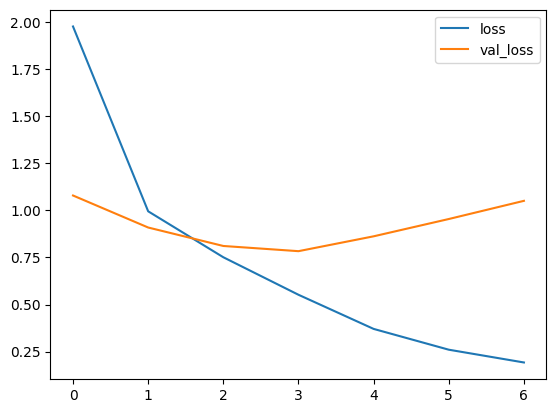

In [40]:
import matplotlib.pyplot as plt
# determine overfitting by checking the metrics
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## 3-6. save trained model

In [41]:
# set model file name
model_filename = 'SpeechCommandRecognition_model.h5'
# Save the model as a file
models.save_model(model, model_filename)

## 3-7. evaluate

In [42]:
# inference on test set
y_pred = np.argmax(model.predict(x_ts), axis=1)
#print(y_pred)
y_true = y_ts
#print (y_true)
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 73%


## 3-8. display a confusion matrix

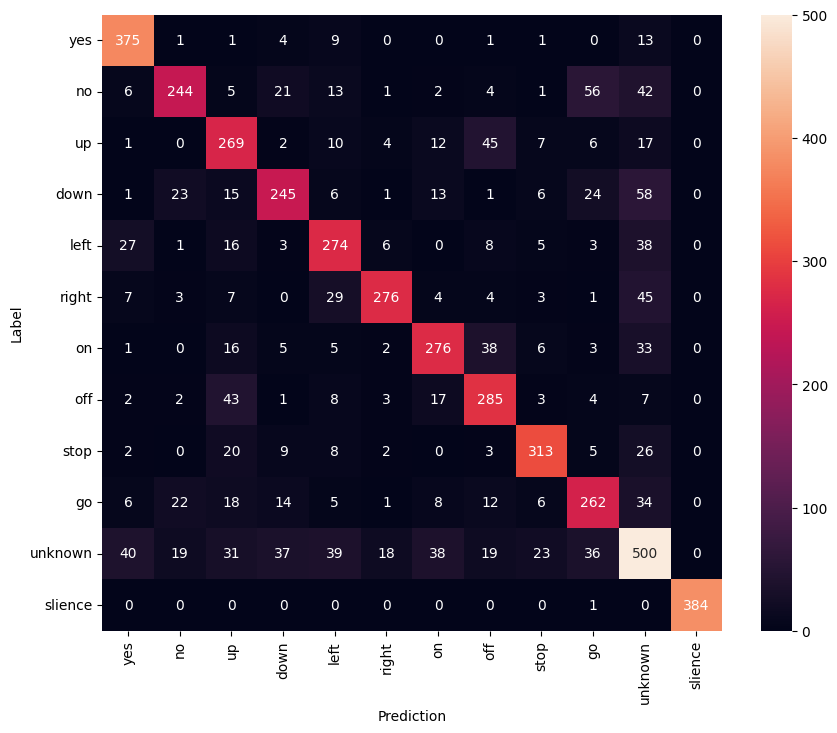

In [43]:
import seaborn as sns
# check the result the confusion_matrix 
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 3-9. run inference on an audio file

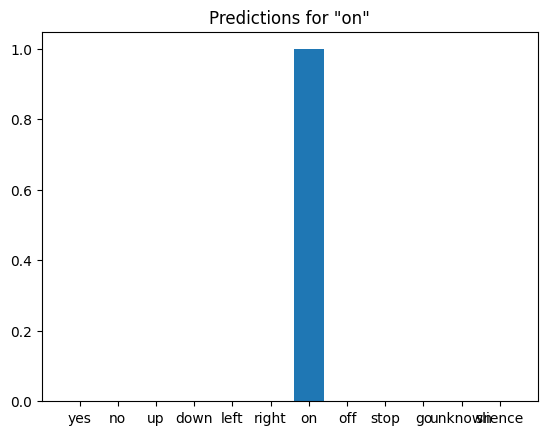

In [44]:
# run inference on an audio file
audio_file = os.path.join(dataset_path, 'on','0ba018fc_nohash_1.wav')
sample_feature = get_features(get_waveform(audio_file))
sample_feature = np.expand_dims(sample_feature, axis=-1)
sample_feature = np.expand_dims(sample_feature, axis=0)

sample_label = get_label(audio_file)
sample_label_id = get_label_id(sample_label, commands)

prediction = model(sample_feature)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for "{commands[sample_label_id]}"')
plt.show()

In [45]:
print(prediction)
print(tf.nn.softmax(prediction[0]))

tf.Tensor(
[[  3.0348253  -8.101813   -3.9109216   5.100772    1.8435833  -1.8918163
   21.867437    5.6194305  -6.6005383  -0.6599144  15.4384    -29.154823 ]], shape=(1, 12), dtype=float32)
tf.Tensor(
[6.6130301e-09 9.6342917e-14 6.3665006e-12 5.2194999e-08 2.0093269e-09
 4.7949762e-11 9.9838853e-01 8.7675822e-08 4.3232947e-13 1.6435964e-10
 1.6114033e-03 6.9280737e-23], shape=(12,), dtype=float32)


# 4. Convert

## 4-1. set parameter

In [46]:
from tensorflow import lite
from tensorflow.keras import models
# set the file name
keras_model_filename = 'SpeechCommandRecognition_model.h5'
tflite_filename = 'SpeechCommandRecognition_model.tflite'
tflite_quantization_filename = 'SpeechCommandRecognition_quantization_model.tflite'

## 4-2. convert (float)

In [47]:
# Convert the model to the TensorFlow Lite format without quantization
model = models.load_model(keras_model_filename)
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_filename, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwhtn9i5o/assets


44784952

In [48]:
! cp SpeechCommandRecognition_model.tflite ../Inference/SpeechCommandRecognition_model.tflite

# 5. Inference (tflite)

In [49]:
'''
! python3 -m pip install tflite-runtime==2.7.0
from tflite_runtime.interpreter import Interpreter
'''

'\n! python3 -m pip install tflite-runtime==2.7.0\nfrom tflite_runtime.interpreter import Interpreter\n'

In [50]:
'''
# Inference Parameters
debug_time = 1
debug_acc = 1
led_pin = 8
word_threshold = 0.5
rec_duration = 0.5
window_stride = 0.1
sample_rate = 48000
resample_rate = 16000
num_channels = 1
num_mfcc = 16
model_path = '../Inference/SpeechCommandRecognition_model.tflite'
'''

"\n# Inference Parameters\ndebug_time = 1\ndebug_acc = 1\nled_pin = 8\nword_threshold = 0.5\nrec_duration = 0.5\nwindow_stride = 0.1\nsample_rate = 48000\nresample_rate = 16000\nnum_channels = 1\nnum_mfcc = 16\nmodel_path = '../Inference/SpeechCommandRecognition_model.tflite'\n"